X-RAY IMAGES ANALYSIS with NEURON NETWORKS

# Introduction

# Training a Convolutional Neural Network to Classify X-Ray Images as Pneumonia or not Pneumonia.
## Background: 

Artificial neural networks have a history dated back in 1943 when Warren McCulloch, a neurophysiologist, and a young mathematician, Walter Pitts, wrote a paper on how neurons might work. They modeled a simple neural network with electrical circuits [1].

Convolutional neural network (CNN) has become a popular model for image and pattern recognition in recent years. But the first single-layer model (ADALINE) was developed at Stanford University by professor Bernard Wildrow and his students in 1959 [1]. It consists of a weight, a bias, and a summation function. The main purpose was to recognize binary patterns by reading streaming bits from a phone line and predict the next bit. Today, it is still used by air traffic control systems. The second model (MADALINE) was developed with 3 layers (input, hidden, and output). It is a fully connected and feeding forward artificial neural network that uses ADALINE units in its hidden and output layers. In 1975, a true multilayered neural network model was developed by Kunihiko Fukushima. The goal was to create a computer that can solve complicated problems like a human brain [1].  

What is a neural network? 

Neural networks are densely interconnected meshes of simple information processors that learn to perform tasks by analyzing huge sets of training data. A neural network, in general, is a highly interconnected network of billions of neurons with trillion interconnections between them [2].

How does it work?

A neural network is a network of neurons that is composed of artificial neurons or nodes. The connections of the neuron are modeled as weights. A positive weight reflects an excitatory connection, while negative values mean inhibitory connections. The basic building blocks of CNN are convolution, pooling, fully connected layer, and output [2]. 

The input is images with shape (number of images), image height, and depth. These images first pass through a layer called the convolution layer. Here, the data is labeled to create a feature map that has "stationary" properties. In this case of x-ray images, the feature could be the outline of the thoracic cavity, two lungs, and the ribs. 

Pooling is a down-sampling operation that reduces the dimensionality of the feature map. The rectified feature map now goes through a pooling layer to generate a pooled feature map. This is achieved by passing the feature map through the whole image one section at the time. A 4x4 matrix for example is reduced to a 2x2 matrix through size filtering, striding, and max or averaging. Image reduction also helps to speed up the computation. 

The next and final step in the process is flattening which results in one single long continuous linear vector which is the input of the fully connected layer. The outcome is the identification of the image. 

Convolutions have three main advantages: reducing overfitting, reducing computational cost, and extracting representative features from input tensor. 

# Libraries used in the project

In [1]:
import os
import glob
import shutil
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from keras import backend as K
from keras.preprocessing import image
import sklearn
from sklearn.metrics import classification_report
%matplotlib inline

Using TensorFlow backend.


# X-Ray Data Use in the Project

The data came from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

## Import Data

Import and save the data into 3 different folders: train, test and validation folders. There are 5206 images in the Train Folder, 624 images in the Test Folder, and 16 images in the Validation Folder. 

In [2]:
from os import listdir
from os.path import isfile, join

In [3]:
def get_images_in_dir(directory, label):
    """
    Returns all images in the directory with the given label.
    Labels can only be 'NORMAL' or 'PNEUMONIA'
    
    Example:
    get_images_in_dir('/some/directory/on/your/computer', 'NORMAL')
    """
    path = join(directory, label)
    return [join(path, f) for f in listdir(path) if isfile(join(path, f))]

train_folder = '/Users/kieuha/XrayProject4/chest_xray/train'
train_normal = get_images_in_dir(train_folder, "NORMAL")
train_pneumonia = get_images_in_dir(train_folder, "PNEUMONIA")

test_folder = '/Users/kieuha/XrayProject4/chest_xray/test'
test_normal = get_images_in_dir(test_folder, "NORMAL")
test_pneumonia = get_images_in_dir(test_folder, "PNEUMONIA")

val_folder = '/Users/kieuha/XrayProject4/chest_xray/val'
val_normal = get_images_in_dir(val_folder, "NORMAL")
val_pneumonia = get_images_in_dir(val_folder, "PNEUMONIA")

print("Train data normal:", len(train_normal))
print("Train data pneumonia:", len(train_pneumonia))

print("Test data normal:", len(test_normal))
print("Test data pneumonia:", len(test_pneumonia))

print("Validation normal:", len(val_normal))
print("Validation penumonia", len(val_pneumonia))

Train data normal: 1331
Train data pneumonia: 3875
Test data normal: 234
Test data pneumonia: 390
Validation normal: 8
Validation penumonia 8


In [4]:
image1 = '/Users/kieuha/XrayProject4/chest_xray/train/PNEUMONIA/person3_bacteria_11.jpeg'

## View sample images

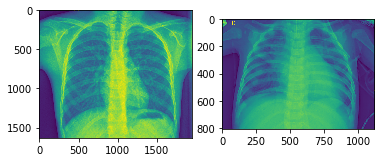

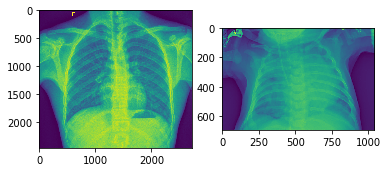

In [87]:
for i in range(2):   
    f, ax = plt.subplots(1,2)
    ax[0].imshow(mpimg.imread(test_normal[i]))
    ax[1].imshow(mpimg.imread(test_pneumonia[i]))
    plt.show()

## Get images ready for the model

### Data Conversion

In [6]:
datagen = ImageDataGenerator(rescale=1./255, 
                            rotation_range=40, 
                            width_shift_range=0.2, 
                            height_shift_range=0.2,
                            shear_range=0.2, 
                            zoom_range=0.2, 
                            horizontal_flip=True, 
                            fill_mode='nearest')


In [7]:
# get all the data in the directory split/train (5206 images), and reshape them
train_generator = datagen.flow_from_directory(
                    train_folder, 
                    target_size=(150, 150), 
                    batch_size = 32, 
                    class_mode='binary')

# get all the data in the directory split/test (16 images), and reshape them
test_generator = datagen.flow_from_directory(
                    test_folder, 
                    target_size=(150, 150), 
                    batch_size = 32,
                    class_mode='binary') 


# get all the data in the directory split/validation (624 images), and reshape them
val_generator = datagen.flow_from_directory(
                val_folder, 
                target_size=(150, 150),
                batch_size = 16,
                class_mode='binary')

Found 5206 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Data Bar Graphs

### Train Data

In [8]:
train_data, train_labels = next(train_generator)
print("Train data shape:", train_data.shape)
print("Train label shape:", train_labels.shape)

Train data shape: (32, 150, 150, 3)
Train label shape: (32,)


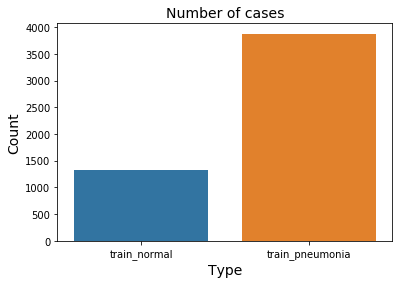

In [9]:
plt.figure(figsize=(6,4))
sns.barplot(x=["train_normal", "train_pneumonia"], \
            y=[len(train_normal), len(train_pneumonia)])
plt.title('Number of cases', fontsize=14)
plt.xlabel('Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

### Test Data

In [10]:
test_data, test_labels = next(test_generator)
print("Test data shape:", test_data.shape)
print("Test label shape:", test_labels.shape)

Test data shape: (32, 150, 150, 3)
Test label shape: (32,)


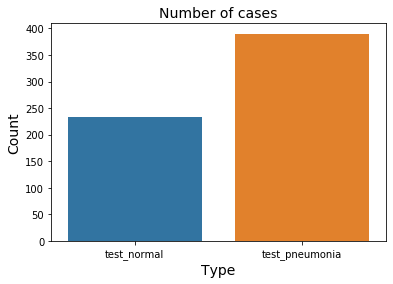

In [11]:
plt.figure(figsize=(6,4))
sns.barplot(x=["test_normal", "test_pneumonia"], \
            y=[len(test_normal), len(test_pneumonia)])
plt.title('Number of cases', fontsize=14)
plt.xlabel('Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

### Validation Data

In [12]:
val_data, val_labels = next(val_generator)
print("Validation data shape:", val_data.shape)
print("Validation label shape:", val_labels.shape)

Validation data shape: (16, 150, 150, 3)
Validation label shape: (16,)


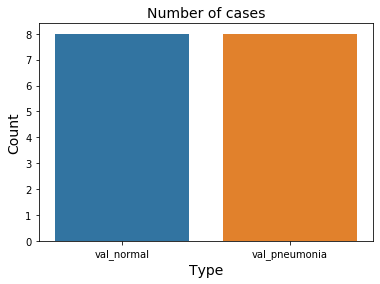

In [13]:
plt.figure(figsize=(6,4))
sns.barplot(x=["val_normal", "val_pneumonia"], \
            y=[len(val_normal), len(val_pneumonia)])
plt.title('Number of cases', fontsize=14)
plt.xlabel('Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

In [77]:
# test_pred_raw = model.predict(test_images)
# test_pred = np.argmax(test_pred_raw, axis=1)

# Convolution Neuron Networks Model

## Build a 3 layers CNN model

In [14]:
# Set random seed
np.random.seed(22)
model = Sequential()
# 1st Convolution 
model.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
# Pooling
model.add(MaxPooling2D((2, 2)))
# 2nd Convolution
model.add(Conv2D(64, (3, 3), activation='relu'))
# Pooling
model.add(MaxPooling2D((2, 2)))
# 3rd Convolution
model.add(Conv2D(128, (3, 3), activation='relu'))
# Pooling
model.add(MaxPooling2D((2, 2)))
# FLatten
model.add(Flatten())
# Fully Connected Layers
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile the Neural Network
model.compile(optimizer= 'adam', loss='binary_crossentropy', \
            metrics=['acc'])
callbacks_list = [EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
model.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________

In [15]:
import datetime
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [16]:
# Use this for real training
history = model.fit(train_generator, 
                    steps_per_epoch=100, 
                    epochs=100, 
                    class_weight={0:3 , 1:1},
                    validation_data=val_generator, 
                    validation_steps=50)


Epoch 1/100
100/100 [==============================] - 188s 2s/step - loss: 1.0297 - acc: 0.5530 - val_loss: 0.5507 - val_acc: 0.6725
Epoch 2/100
100/100 [==============================] - 155s 2s/step - loss: 0.7160 - acc: 0.7716 - val_loss: 0.6946 - val_acc: 0.7125
Epoch 3/100
100/100 [==============================] - 159s 2s/step - loss: 0.6348 - acc: 0.8003 - val_loss: 0.7009 - val_acc: 0.7750
Epoch 4/100
100/100 [==============================] - 158s 2s/step - loss: 0.5692 - acc: 0.8233 - val_loss: 1.0373 - val_acc: 0.7663
Epoch 5/100
100/100 [==============================] - 151s 2s/step - loss: 0.4909 - acc: 0.8541 - val_loss: 0.6373 - val_acc: 0.8037
Epoch 6/100
100/100 [==============================] - 154s 2s/step - loss: 0.5198 - acc: 0.8549 - val_loss: 0.6636 - val_acc: 0.7487
Epoch 7/100
100/100 [==============================] - 154s 2s/step - loss: 0.4630 - acc: 0.8611 - val_loss: 0.7816 - val_acc: 0.8100
Epoch 8/100
100/100 [==============================] - 153s 2

100/100 [==============================] - 173s 2s/step - loss: 0.2381 - acc: 0.9317 - val_loss: 0.2902 - val_acc: 0.8825
Epoch 61/100
100/100 [==============================] - 174s 2s/step - loss: 0.2156 - acc: 0.9331 - val_loss: 0.4564 - val_acc: 0.8288
Epoch 62/100
100/100 [==============================] - 173s 2s/step - loss: 0.2261 - acc: 0.9320 - val_loss: 0.4336 - val_acc: 0.8913
Epoch 63/100
100/100 [==============================] - 173s 2s/step - loss: 0.2130 - acc: 0.9404 - val_loss: 0.2295 - val_acc: 0.8625
Epoch 64/100
100/100 [==============================] - 173s 2s/step - loss: 0.2173 - acc: 0.9356 - val_loss: 0.4448 - val_acc: 0.8050
Epoch 65/100
100/100 [==============================] - 172s 2s/step - loss: 0.2106 - acc: 0.9389 - val_loss: 0.3119 - val_acc: 0.8800
Epoch 66/100
100/100 [==============================] - 173s 2s/step - loss: 0.2083 - acc: 0.9398 - val_loss: 0.1752 - val_acc: 0.8938
Epoch 67/100
100/100 [==============================] - 172s 2s/step

In [17]:
end = datetime.datetime.now()
elapsed = end - start
print('Training with data augmentation took a total of {}'.format(elapsed))

Training with data augmentation took a total of 4:47:27.433702


## Save the model

In [18]:
# save for future use.
model.save('./is_pneumonia.kerasmodel')

import pickle
with open('./is_pneumonia.kerashistory', 'wb') as file_pi:
    pickle.dump(history, file_pi)

In [21]:
import tensorflow as tf
# model = tf.keras.models.load_model('./is_pneumonia.kerasmodel')

# history = pickle.load(open('./is_pneumonia.kerashistory', 'rb')

## Evaluate the model

In [83]:
train_mse = model.evaluate(train_generator, verbose=0)
test_mse = model.evaluate(test_generator, verbose=0)
val_mse = model.evaluate(val_data, val_labels, verbose =0)
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)
print("Val MSE:", val_mse)

Train MSE: [0.16820164024829865, 0.9492892622947693]
Test MSE: [0.9573003053665161, 0.8333333134651184]
Val MSE: [0.07695193588733673, 1.0]


## Loss history

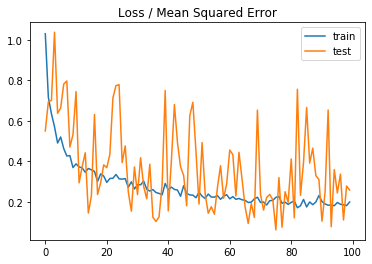

In [30]:
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

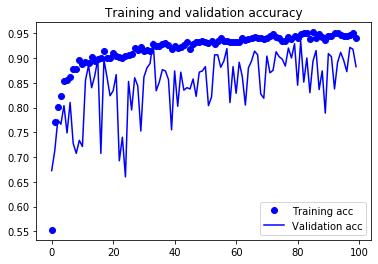

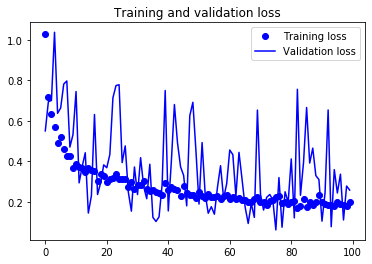

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [32]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 5:56:52.015583


In [33]:
model.save('chest_xray_downsampled_data.h5')

## Confusion Matrix

In [44]:
y_pred = model.predict(test_data)

In [45]:
confusion = sklearn.metrics.confusion_matrix(test_labels, y_pred>0.625)
accuracy = (confusion[1, 1] + confusion[0, 0])/sum(sum(confusion))
precision = confusion[1,1]/(confusion[1,1] + confusion[0, 1])
recall = confusion[1,1]/(confusion[1,1] + confusion[1, 0])
print(classification_report(test_labels, y_pred>0.625))

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95        10
         1.0       0.96      1.00      0.98        22

    accuracy                           0.97        32
   macro avg       0.98      0.95      0.96        32
weighted avg       0.97      0.97      0.97        32



In [36]:
test_labels

array([0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1.],
      dtype=float32)

In [37]:
test_data

array([[[[0.66739094, 0.66739094, 0.66739094],
         [0.65113765, 0.65113765, 0.65113765],
         [0.6595001 , 0.6595001 , 0.6595001 ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.67615646, 0.67615646, 0.67615646],
         [0.66766477, 0.66766477, 0.66766477],
         [0.6510008 , 0.6510008 , 0.6510008 ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.67619866, 0.67619866, 0.67619866],
         [0.6762021 , 0.6762021 , 0.6762021 ],
         [0.66793853, 0.66793853, 0.66793853],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [46]:
from sklearn.metrics import classification_report

print("Test Label:", len(test_labels))
print("Test Predict:", len(test_data))
confusion = sklearn.metrics.confusion_matrix(test_labels, y_pred>0.625)
accuracy = (confusion[1, 1] + confusion[0, 0])/sum(sum(confusion))
precision = confusion[1,1]/(confusion[1,1] + confusion[0, 1])
recall = confusion[1,1]/(confusion[1,1] + confusion[1, 0])

Test Label: 32
Test Predict: 32


In [39]:
class ImpersonatedSklearnModel:
    def __init__(self, model, threshold = 0.625):
        self.model = model
        self._estimator_type = 'classifier'
        self.classes_ = ["Normal", "Pneumonia"]
        self.threshold = threshold
        
    def predict(self, x):
        return self.model.predict(x) > self.threshold
    
my_model = ImpersonatedSklearnModel(model, threshold=0.5)

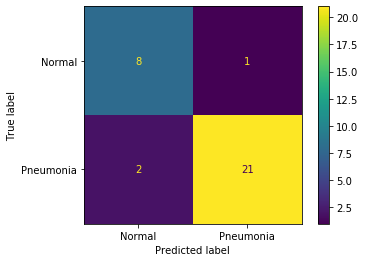

In [48]:
sklearn.metrics.plot_confusion_matrix(my_model, train_data, train_labels) 
plt.show()

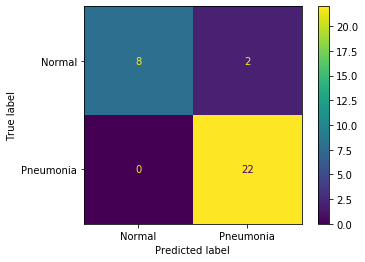

In [47]:
sklearn.metrics.plot_confusion_matrix(my_model, test_data, test_labels) 
plt.show()

Note: the data is represented by batches. There are 32 batches for training and 32 batches for testing. 

# Visualizing Intermediate Activations

## Sample Image

In [50]:
img_path = train_normal[45]
img_path

'/Users/kieuha/XrayProject4/chest_xray/train/NORMAL/NORMAL2-IM-1196-0001.jpeg'

In [51]:
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

(1, 150, 150, 3)


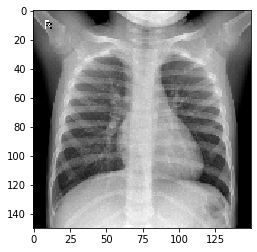

In [52]:
#Follow the Original Model Preprocessing
img_tensor /= 255.

#Check tensor shape
print(img_tensor.shape)

#Preview an image
plt.imshow(img_tensor[0])
plt.show()

In [60]:
from keras import models

In [61]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers[:8]]

# Display the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

(1, 148, 148, 32)


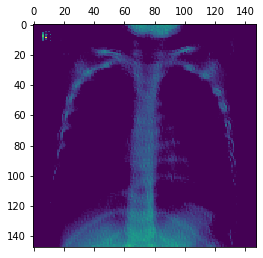

In [62]:
# Return an array for each activation layer
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# Slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

(1, 148, 148, 32)


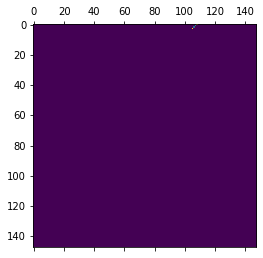

In [63]:
# Repeating the process for another channel (the 30th)
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

## Feature Map Visualizations

Neural networks build up their understanding of images through textures, patterns, edges, parts, and objects. 
Each set of the images below represents different layers of the feature map.

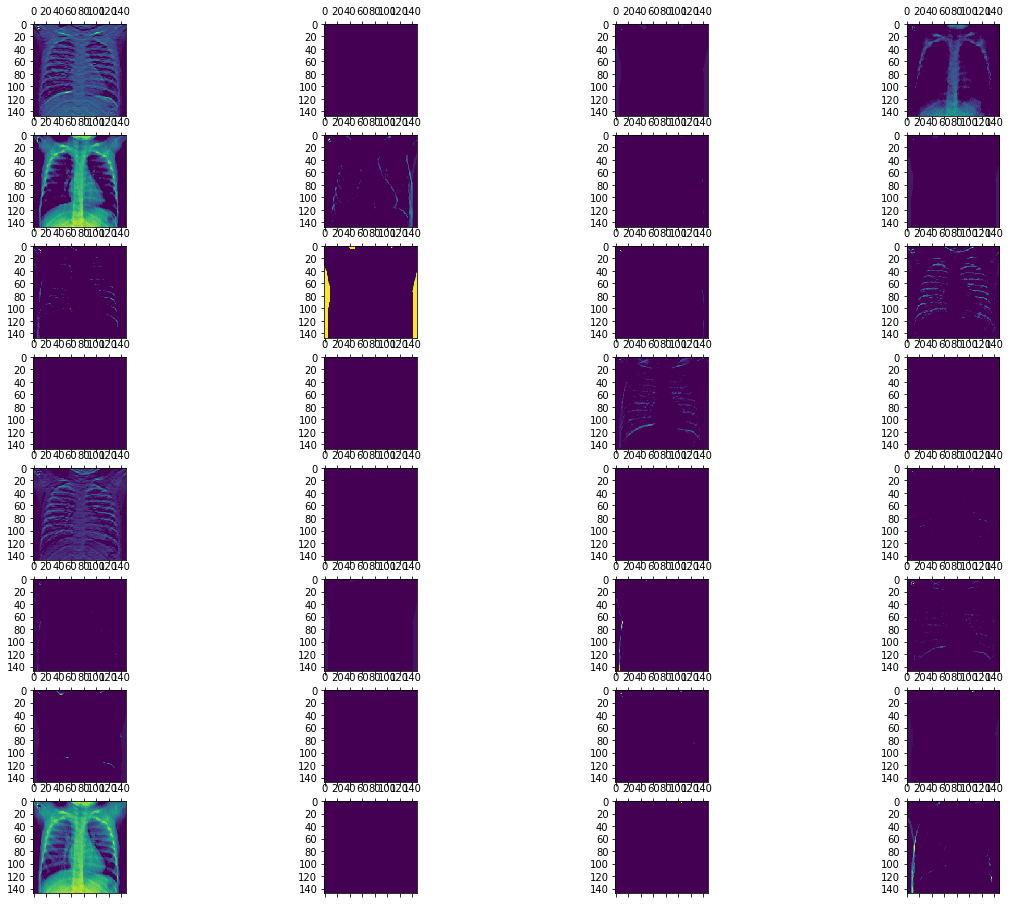

In [88]:
fig, axes = plt.subplots(8, 4, figsize=(20,16))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

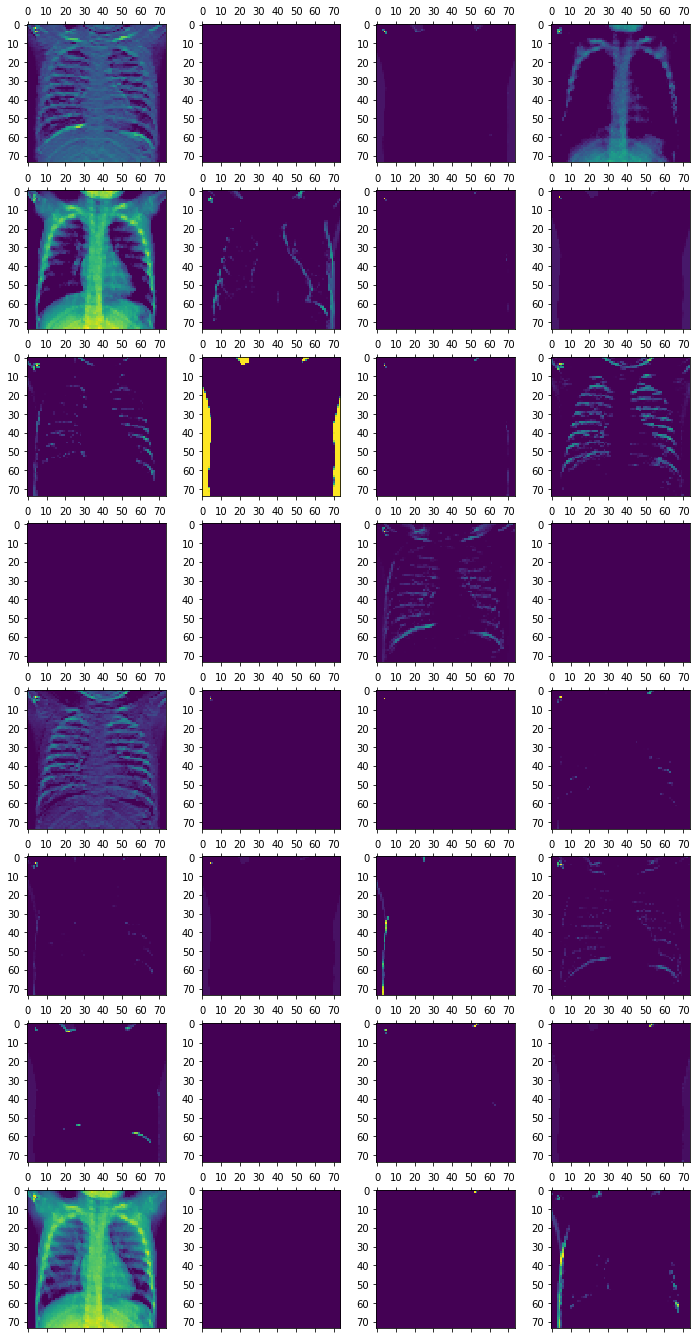

In [67]:
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    second_layer_activation = activations[1]
    ax.matshow(second_layer_activation[0, :, :, i], cmap='viridis')

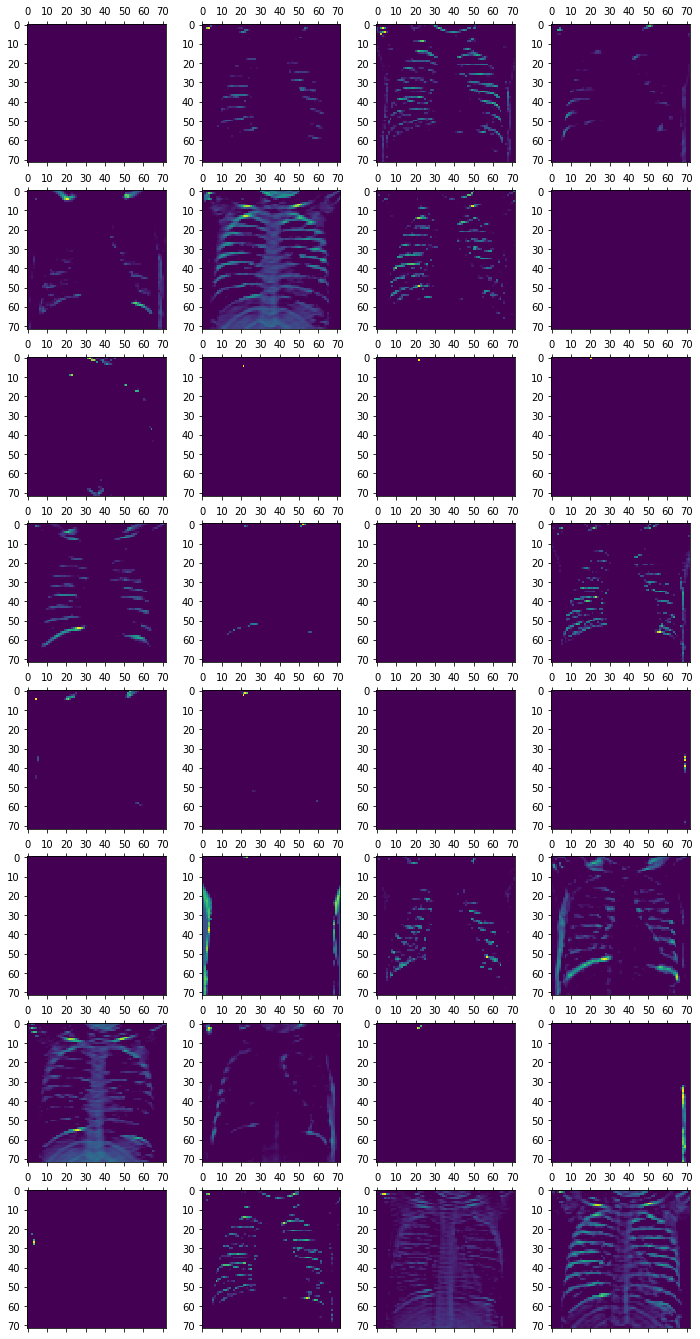

In [68]:
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    third_layer_activation = activations[2]
    ax.matshow(third_layer_activation[0, :, :, i], cmap='viridis')

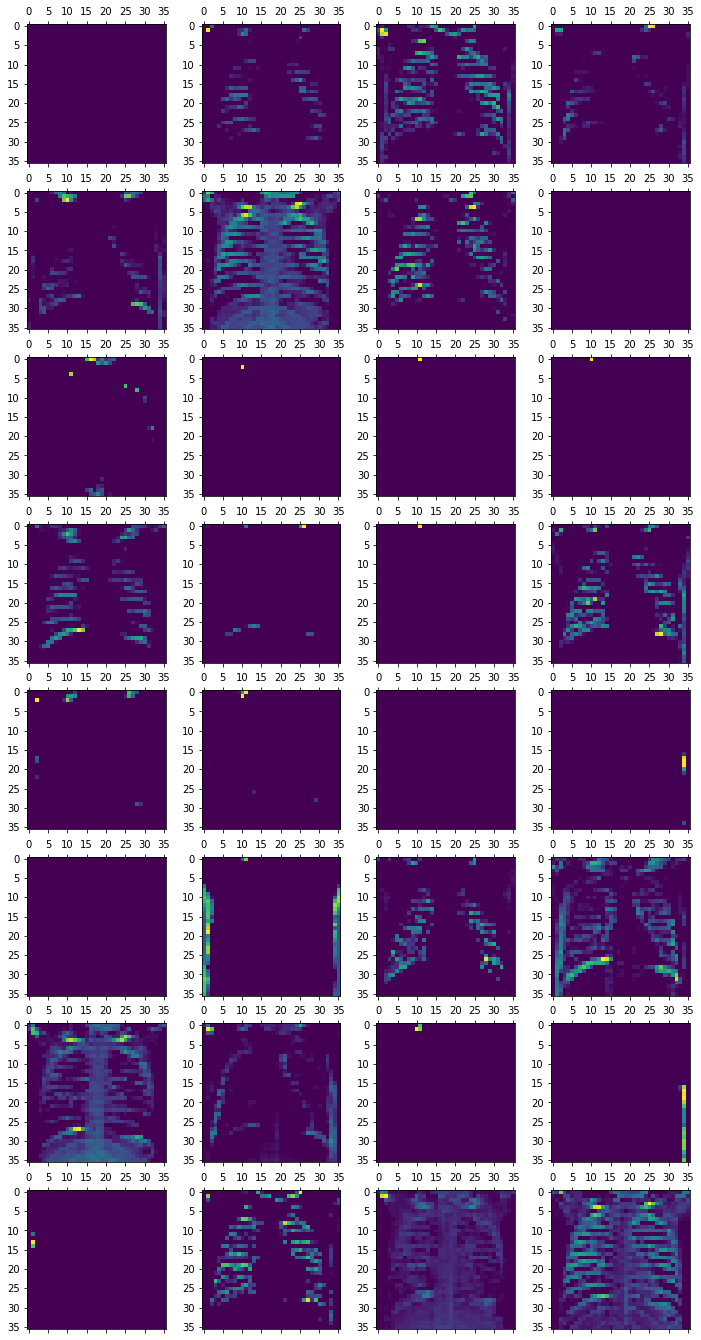

In [69]:
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    fourth_layer_activation = activations[3]
    ax.matshow(fourth_layer_activation[0, :, :, i], cmap='viridis')

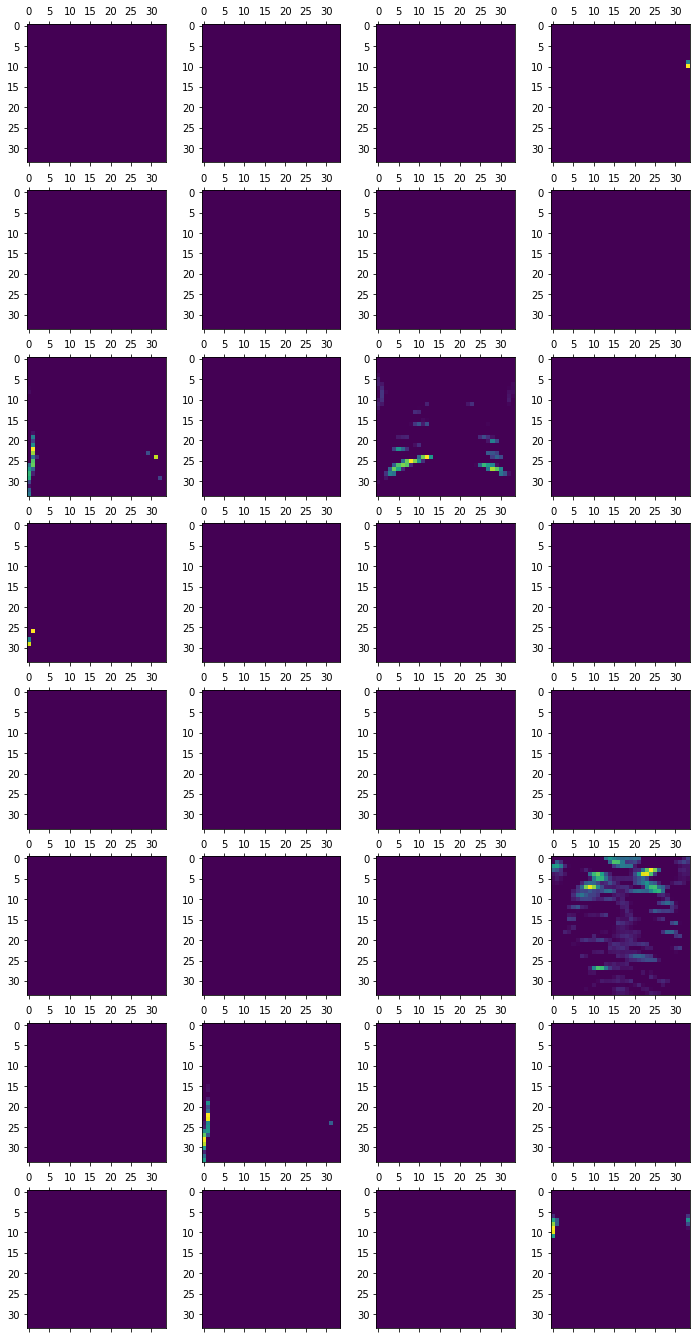

In [70]:
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    fifth_layer_activation = activations[4]
    ax.matshow(fifth_layer_activation[0, :, :, i], cmap='viridis')

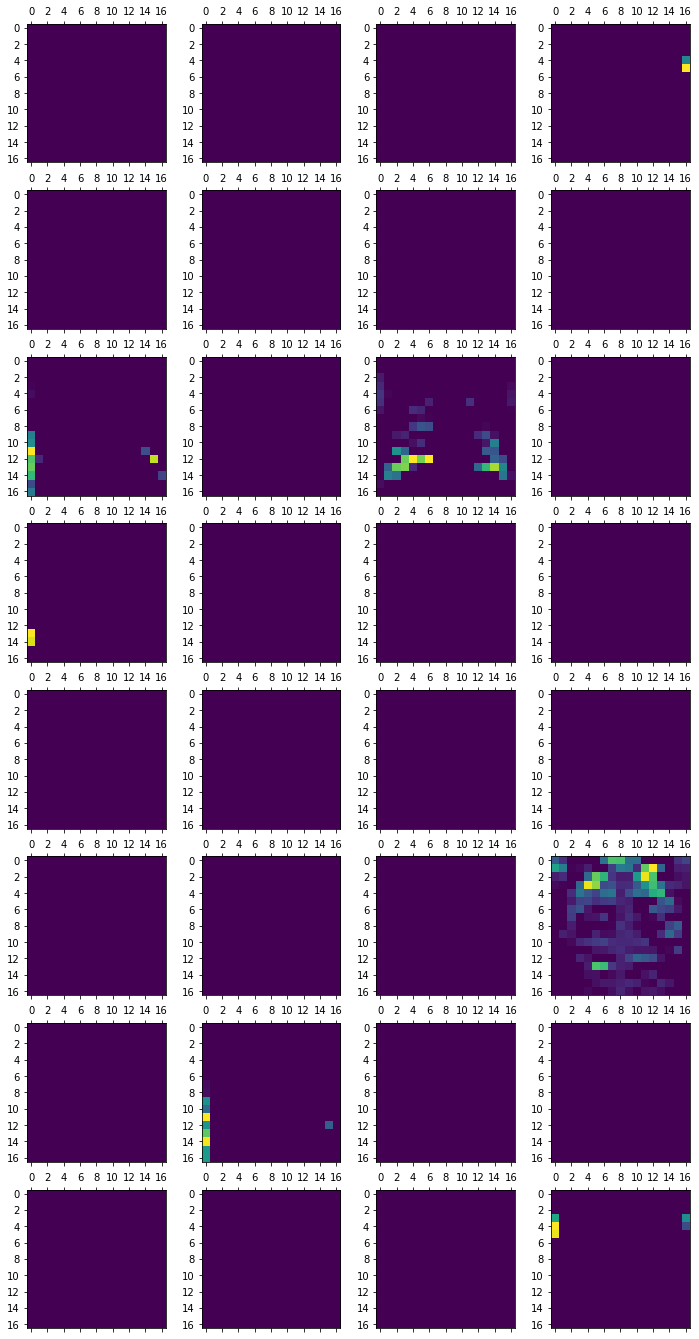

In [71]:
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    sixth_layer_activation = activations[5]
    ax.matshow(sixth_layer_activation[0, :, :, i], cmap='viridis')

# Conclusion

Neural networks build up their understanding of images through textures, patterns, edges, parts, and objects. The model has an accuracy score of 83% using 234 normal images and 390 pneumonia positive images. As shown in the feature map visualization, the model successfully extracted different features of the image. The proposed model can potentially be served as an independent method to verify x-ray-technologists on pneumonia diagnosis after going through extensive evaluation and validation. Analyzing x-ray images by the model offers many advantages such as its ability to quickly scan through images and classify them. Thousands of images can be done in a matter of hours. As the result, x-ray images analysis can help lower the cost of the treatment, provides doctors with information quicker, and reduces clinician workload especially during the ongoing pandemic as we are going through with Covid-19 at the moment. 

# References

1. Neural Networks. Standford University. https://cs.stanford.edu/people/eroberts/courses/soco/projects/neural-networks/History/history1.html

2. Rikiya Yamashita, Mizuho Nishio, Richard Kinh Gian Do, Kaori Togashi
Insights Imaging. 2018 Aug; 9(4): 611–629. Published online 2018 Jun 22. doi: 10.1007/s13244-018-0639-9
